In [2]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401
import re, glob


# Plot CPU times for IMEX-RB on 2D nonlinear problem
We study CPU times on the 2D viscous Burgers equation

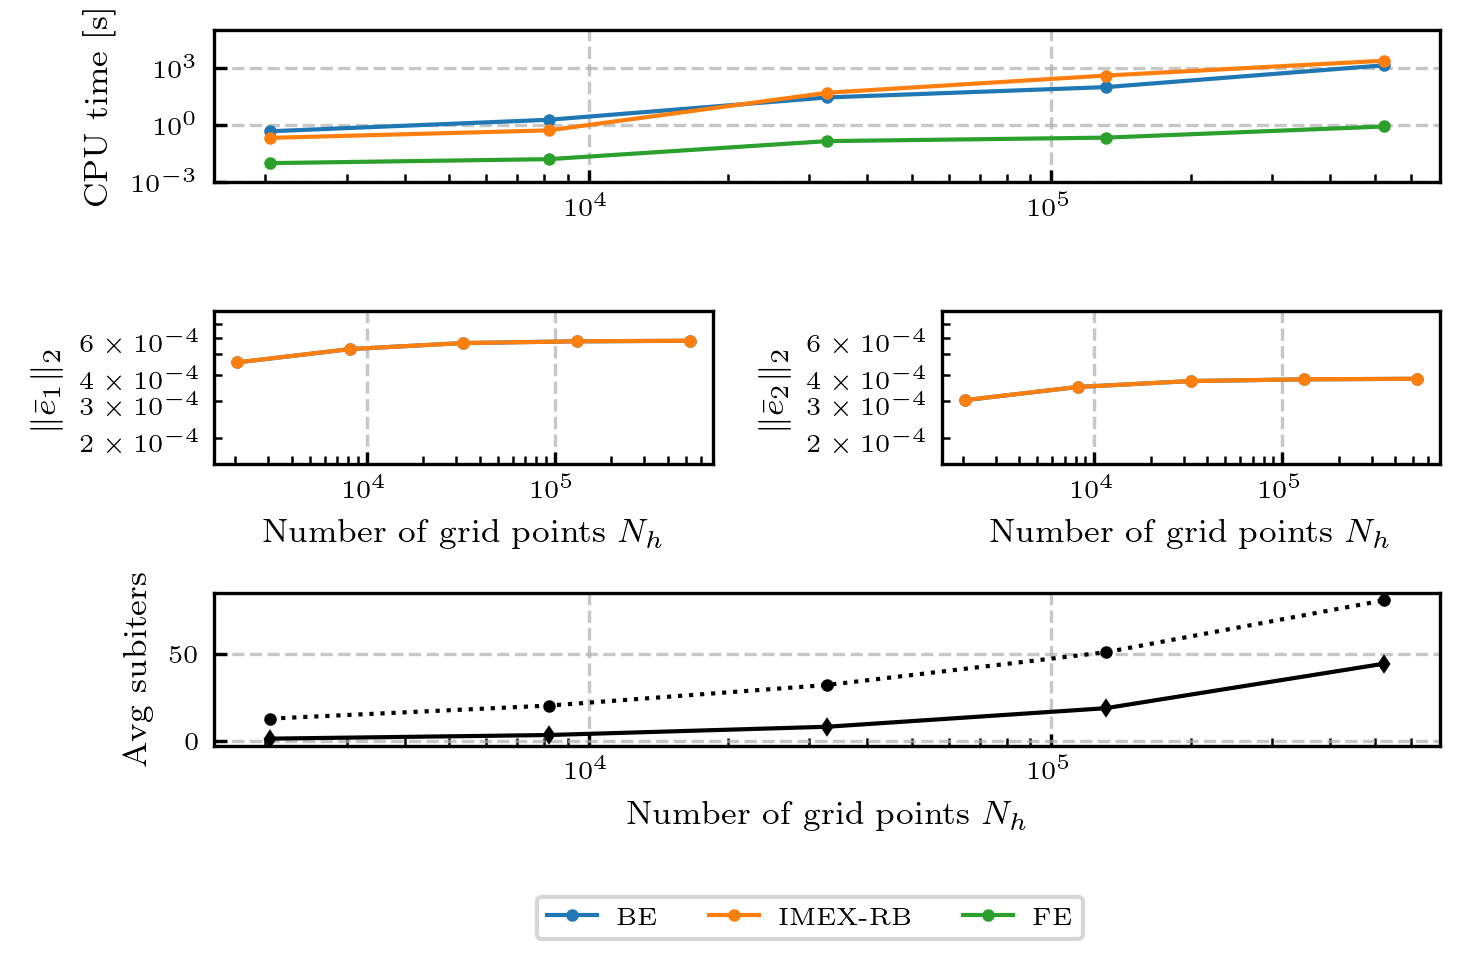

In [18]:
# Retrieve data
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))

# Paths
problem_name = "Burgers2D"
test_name = "CPUtimes"
# Find results
results_base = os.path.join(base_dir, os.pardir, os.pardir, 'results', problem_name)
convergence_dirs = glob.glob(os.path.join(results_base, f'{test_name}*'))
latest_num = max([int(re.search(rf'{test_name}(\d+)', os.path.basename(d)).group(1)) for d in convergence_dirs])
results_path = os.path.join(results_base, f'{test_name}{latest_num}', 'results.npz')

plots_dir = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
times = data['times'].item()
errors_l2 = data['errors_l2'].item()
Nh_values = data['Nh_values']
subiters = data['subiters'].item()['IMEX-RB']

methods = ['BE', 'IMEX-RB', 'FE']
comp_labels = ['u_x', 'u_y']

# Create subplot grid: 3 rows, 2 columns
fig = plt.figure(figsize=(5, 3))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1])

# First row: CPU times (spans both columns)
ax1 = fig.add_subplot(gs[0, :])
for m in methods:
    ax1.loglog(Nh_values, times[m], marker='o', label=m)
ax1.set_ylabel('CPU time [s]')
ax1.set_ylim((1e-3, 1e5))

# Second row: L2 errors for each component (2 separate plots)
ax2 = fig.add_subplot(gs[1, 0])
for m in methods[:-1]:
    ax2.loglog(Nh_values, errors_l2[m][0], marker='o', label=m)
ax2.set_ylabel(fr'$\|\bar{{e}}_1\|_2$')
ax2.set_ylim((1.5e-4, 8e-4))

ax3 = fig.add_subplot(gs[1, 1])
for m in methods[:-1]:
    ax3.loglog(Nh_values, errors_l2[m][1], marker='o', label=m)
ax3.set_ylabel(fr'$\|\bar{{e}}_2\|_2$')
ax3.set_ylim((1.5e-4, 8e-4))

# Third row: Average sub-iterations (spans both columns)
ax4 = fig.add_subplot(gs[2, :])
ax4.semilogx(Nh_values, np.mean(subiters, axis=1), color='k', marker='d', linestyle="-")
ax4.semilogx(Nh_values, [np.pow(Nh, 1/(3)) for Nh in Nh_values], color='k', marker='o', linestyle=":")
ax4.set_ylabel(fr'Avg subiters')
ax4.set_xlabel('Number of grid points $N_h$')

# Set x-axis label for the middle row plots as well
ax2.set_xlabel('Number of grid points $N_h$')
ax3.set_xlabel('Number of grid points $N_h$')

fig.legend(methods, bbox_to_anchor=(0.55, -0.01), loc='upper center', ncol=3)
plt.tight_layout()
out_file = os.path.join(
    plots_dir, 'Burgers2D_cputimes_errors.pdf'
)
plt.savefig(out_file)
plt.show()
plt.close()